### 策略改进方向
* 对TrendModelStrategy策略改进可以拆分成下面若干步骤
    * 对策略性能进行深刻分析
    
    * 通过*trade by trade* 的方式评估每笔交易：
    * 通过*trade by trade* 的方式评估滑点和交易费用的影响
    * 通过*trade by trade* 的方式评估 *Trend Model*的表现：
        * 模型在回测区间的准确率 $Accuracy_{TrendModel}$
            * $Accuracy_{TrendModel}$ 在不同时间，不同方向上的表现
    * 通过*trade by trade*的方式提取出每笔交易的入场时间：
        * 评估 *持仓时间* 对*NetPnl*的影响
        * 评估 *不同止盈和止损点位*对*NetPnl*的影响
       
#### 评估 TrendModel Performance
* 每笔头寸的实际盈亏情况
* 模型正确识别入场时机的准确率
    * 在设置好交易费用和佣金的前提下，统计交易盈利达到阈值的次数$Trade_{positive}$占总交易次数 $Trade_{total}$的比率
#### 模型本身的止盈和止损设置    
#### diff的周期
* 5，15，30

### 评估 TrendModel Performance

#### *Trade by trade* 评估每笔交易
* 通过*trade by trade* 的方式评估 *Trend Model*的表现：
     * $Accuracy_{TrendModel}$ 在不同时间，不同方向上的表现
* 通过*trade by trade* 的方式评估滑点和交易费用的影响
* 通过*trade by trade*的方式提取出每笔交易的入场时间：
    * 评估 *持仓时间* 对*NetPnl* 的影响
    * 评估 *不同止盈和止损点位* 对 *NetPnl* 的影响
    
#### 评估指标定义
* $Trade_{positive}$ 表示 $NetPnL$ 大于最小盈利阈值的*trade*
* $Accuracy_{TrendModel}$ = $Number(Trade_{positive}) / Number(Trade_{total}) $



In [1]:
import numpy as np
import pandas as pd
from vnpy.app.cta_strategy.backtesting import BacktestingEngine, OptimizationSetting
from datetime import datetime
from trend_model import TrendModelStrategy
from trade_by_trade import (calculate_trades_result, generate_trade_df)
import matplotlib.pyplot as plt

In [2]:
engine = BacktestingEngine()
engine.set_parameters(
    vt_symbol="IF888.CFFEX",
    interval="1m",
    start=datetime(2014, 10, 1),
    end=datetime(2018, 12, 30),
    slippage=0.2,
    rate=0.3/10000,
    size=300,
    pricetick=0.2,
    capital=1_000_000,
)
engine.add_strategy(TrendModelStrategy, {})
engine.load_data()
# engine.run_backtesting()

2020-04-16 09:06:24.519063	开始加载历史数据
2020-04-16 09:06:25.354086	加载进度： [2%]
2020-04-16 09:06:26.266710	加载进度： [4%]
2020-04-16 09:06:27.093191	加载进度： [6%]
2020-04-16 09:06:27.826989	加载进度： [8%]
2020-04-16 09:06:28.586241	加载进度： [10%]
2020-04-16 09:06:29.347336	加载进度：# [12%]
2020-04-16 09:06:30.083550	加载进度：# [14%]
2020-04-16 09:06:30.969946	加载进度：# [15%]
2020-04-16 09:06:31.693570	加载进度：# [17%]
2020-04-16 09:06:32.607477	加载进度：# [19%]
2020-04-16 09:06:33.396890	加载进度：## [21%]
2020-04-16 09:06:34.095146	加载进度：## [23%]
2020-04-16 09:06:34.695421	加载进度：## [25%]
2020-04-16 09:06:35.689526	加载进度：## [27%]
2020-04-16 09:06:36.519045	加载进度：## [29%]
2020-04-16 09:06:37.209191	加载进度：### [31%]
2020-04-16 09:06:37.743296	加载进度：### [33%]
2020-04-16 09:06:38.647742	加载进度：### [35%]
2020-04-16 09:06:39.305459	加载进度：### [37%]
2020-04-16 09:06:39.963454	加载进度：### [39%]
2020-04-16 09:06:40.604064	加载进度：#### [41%]
2020-04-16 09:06:41.717982	加载进度：#### [43%]
2020-04-16 09:06:42.551475	加载进度：#### [44%]
2020-04-16 09:06:43.133131	加载

In [119]:
trade_df_without_fee = generate_trade_df(engine.trades,size=1, rate=0, slippage=0,capital=100_00_00)
threshold_return = 0
model_accuracy_without_fee = np.sum(trade_df_without_fee['net_pnl']>threshold_return)/trade_df_without_fee['net_pnl'].shape[0]

In [120]:
trade_df_with_fee = generate_trade_df(engine.trades,size=1, rate=0.3/10000, slippage=0.2,capital=100_00_00)
threshold_return = 0
model_accuracy_with_fee = np.sum(trade_df_with_fee['net_pnl']>threshold_return)/trade_df_with_fee['net_pnl'].shape[0]

#### 可视化滑点和手续费对*NetPnl*的影响

- 下图1-1可视化了 *Trend Model Strategy with and without fee* (滑点和交易费用）的NetPnL变化
    - 为了更深入的研究 *fee*的影响，在图1-1中嵌入了*fees*曲线（主要刻画了滑点的变化）
    - $fees = fee（slipping）+fee（commission）$ 且 $fee（commission）$在回测中是固定值
    
##### 图形分析   
- *fee* 对于 *Trend Model Strategy* 的 *NetPnl* 影响体现在 2条曲线趋势不同的时候：

    - *2015-02-06* 时间段 *with_fee*曲线呈总体上升趋势，而*without_fee*曲线呈总体下降趋势
    
    - *2015-09 - 2016-05* 时间段 *with_fee*曲线呈总体上升趋势，而*without_fee*曲线呈总体呈震荡横盘趋势
    
    - *2016-05 - 2017-10* 时间段 *with_fee*曲线呈总体震荡缓慢向上趋势，而*without_fee*曲线呈总体45°向下趋势
    
- 总体来说，大部分时间段内 *with_fee* 曲线 和 *without_fee* 曲线呈现了不同趋势：

    - *fees*曲线和*without_fee*曲线总体呈相反关系，这说明了大部分*Gross PnL* 都是小赚，没办法覆盖交易佣金和滑点*fee*
    
##### 未来方向
- 基于上面的研究结果，下一步研究方向：
    - 1.信号过滤：
        - 想办法过滤掉 *Gross PnL* 不足以覆盖交易佣金和滑点*fee*的trade：
            - 1.开发一个*Sub Model*使用其它的技术指标（feature）
            - 2.直接把滑点作为一个过滤器，过滤交易（不同时间段设置不同滑点阈值）
    - 2. 止盈止损点位：
        - 当前分析的*trade*只基于策略中的止盈止损点。改变了止盈和止损点也许会对策略表现有影响
    - 3. 模型精准度研究：
        - 模型性能的进一步分析



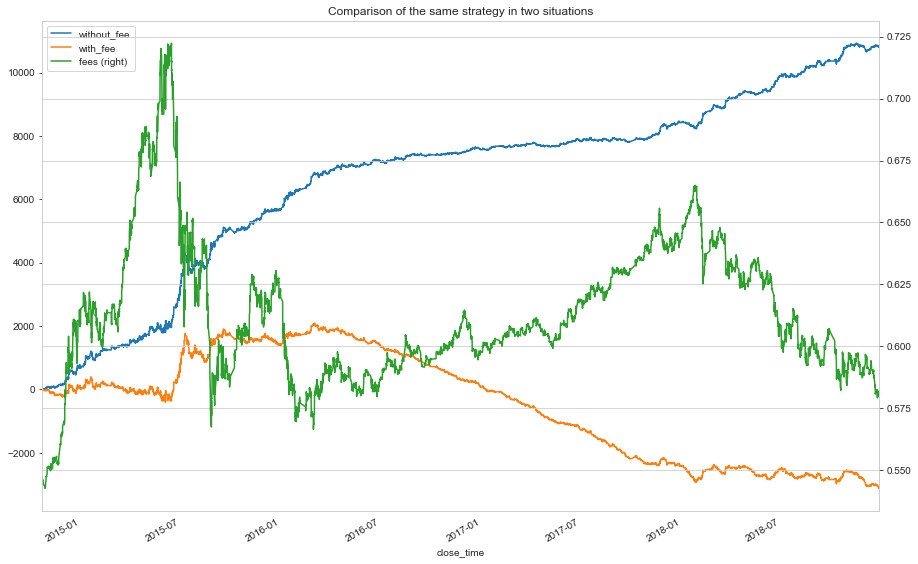

In [121]:
pnl_without_fee = trade_df_without_fee['acum_pnl'].values
pnl_with_fee = trade_df_with_fee['acum_pnl'].values
fees = (trade_df_with_fee['slipping']+trade_df_with_fee['commission']).values
two_pnl_df = pd.DataFrame({'without_fee':pnl_without_fee,'with_fee':pnl_with_fee,'fees': fees},index=trade_df_with_fee.close_time)
two_pnl_df[['without_fee','with_fee','fees']].plot(secondary_y='fees',figsize=(15,10),title='Comparison of the same strategy in two situations')

#### 可视化模型准确率

- 下图1-2可视化了 *Trend Model Strategy with and without fee* (滑点和交易费用）的模型 *Accuracy*
    - $Accuracy_{TrendModel}$ = $Number(Trade_{positive})/Number(Trade_{total}) $
    - 为了研究模型*accuracy*在不同市场阶段的表现，在图1-1中嵌入了*close*曲线（主要刻画市场趋势）
    
- 下图1-3可视化了 *Trend Model Strategy with and without fee* (滑点和交易费用）的模型 在不同方向上的*Accuracy* 
    
    - 下图1-5可视化了 *Trend Model Strategy with and without fee* (滑点和交易费用）的模型 在*short_side*的*Accuracy* 


    
##### 图形分析  
* 图1-2：
    - 从*without_fee*的曲线可以得出，价格趋势似乎对模型的*Accuracy*变化不大（可能由于策略本身多空双向）
    - *without_fee* 和*with_fee*曲线的*difference*在*2016-09 - 2018-01*呈发散的趋势，这是由*slippge*在该时间段内增大导致。

    -
* 图1-5：
    - *without_fee，with_fee* 曲线在从*2015-07*以后均呈下降趋势（部分熊市和慢牛）
    - 这说明了需要对*Trend Model* 的*short_side* 信号做优化。


#### 空中花园（将跳空作为信号进行考量）

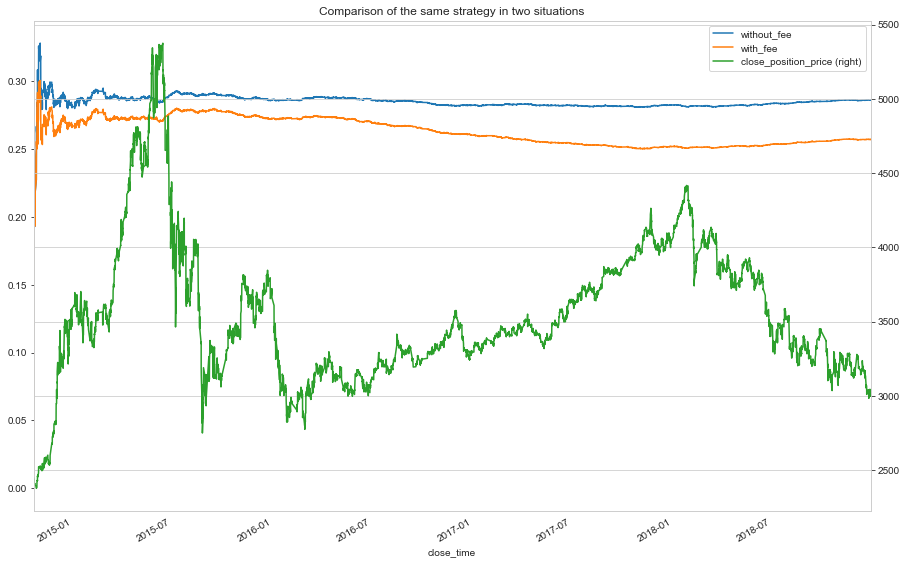

In [122]:
threshold = 0
side=np.where(trade_df_with_fee['close_direction']=='多',1,-1)
pnl_without_fee = trade_df_without_fee['net_pnl'].values
pnl_with_fee = trade_df_with_fee['net_pnl'].values
actual_with_fee = np.where(trade_df_with_fee['net_pnl']>threshold,1,0)
actual_without_fee = np.where(trade_df_without_fee['net_pnl']>0,1,0)
predict_with_fee = np.ones(shape=(trade_df_with_fee.shape[0],))
predict_num = predict_with_fee.cumsum()
actual_result_cum_with_fee = actual_with_fee.cumsum()
actual_result_cum_without_fee = actual_without_fee.cumsum()
accuracy_with_fee =  actual_result_cum_with_fee/predict_num
accuracy_without_fee =  actual_result_cum_without_fee/predict_num
close_position_price = trade_df_with_fee['close_price'].values
two_accuracy_df = pd.DataFrame({'without_fee':accuracy_without_fee,'with_fee':accuracy_with_fee,'close_position_price':close_position_price,
                                'side':side,'actual_with_fee':actual_with_fee,'actual_without_fee':actual_without_fee },index=trade_df_with_fee.close_time)
two_accuracy_df[['without_fee','with_fee','close_position_price']].plot(secondary_y='close_position_price',figsize=(15,10),title='Comparison of the same strategy in two situations')

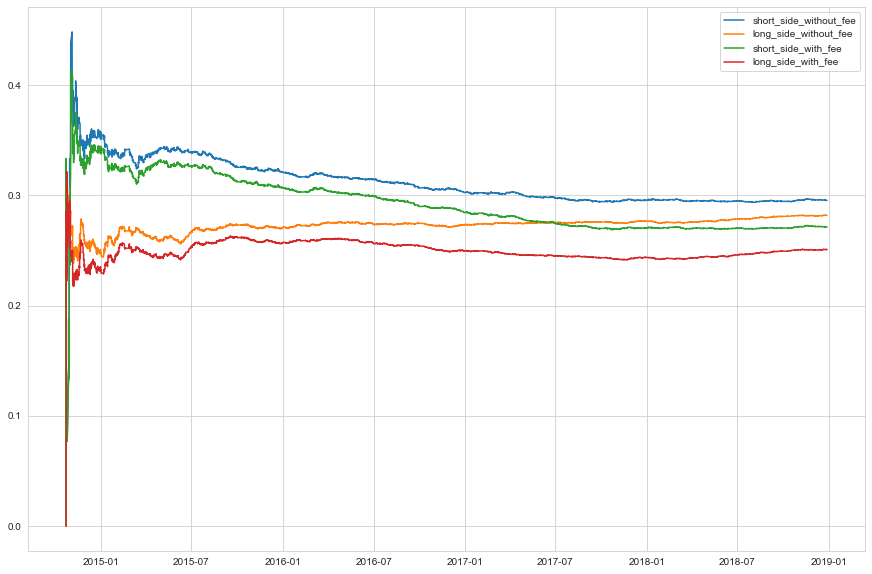

In [123]:
two_accuracy_df['num'] = 1
long_side = two_accuracy_df[two_accuracy_df['side']==1]
short_side = two_accuracy_df[two_accuracy_df['side']==-1]
long_accuracy_with_fee = long_side['actual_with_fee'].cumsum()/long_side['num'].cumsum()
long_accuracy_without_fee = long_side['actual_without_fee'].cumsum()/long_side['num'].cumsum()
short_accuracy_with_fee = short_side['actual_with_fee'].cumsum()/short_side['num'].cumsum()
short_accuracy_without_fee = short_side['actual_without_fee'].cumsum()/short_side['num'].cumsum()
figure = plt.figure(figsize=(15,10))
plt.plot(short_accuracy_without_fee,label='short_side_without_fee')
plt.plot(long_accuracy_without_fee, label='long_side_without_fee')
plt.plot(short_accuracy_with_fee,label='short_side_with_fee')
plt.plot(long_accuracy_with_fee,label='long_side_with_fee')

plt.legend()

- 下图1-4可视化了 *Trend Model Strategy with and without fee* (滑点和交易费用）的模型 在*long_side*的*Accuracy* 
* 图1-4：
    - *without_fee，with_fee* 曲线在*2015-05-2015-09*呈下跌趋势（熊市）
    - *without_fee* 曲线在*2015-09-2018-01*整体变化不大
    - *without_fee，with_fee* 曲线在*2017-12-2018-01*时间段呈不同趋势（此时间段的*Gross Pnl*基本上无法覆盖滑点）

<Figure size 1080x720 with 0 Axes>

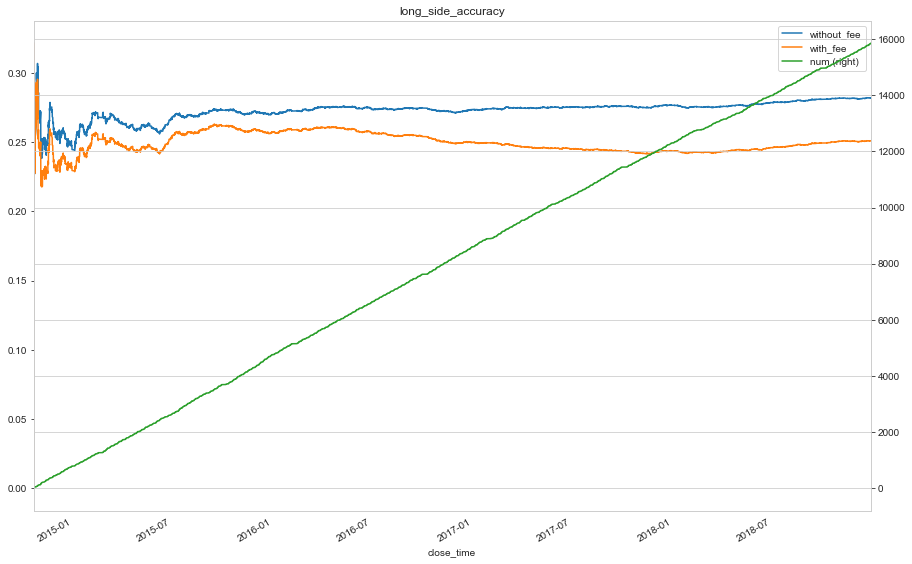

In [124]:
figure = plt.figure(figsize=(15,10))
long_accuracy_df = pd.DataFrame({'with_fee':long_accuracy_with_fee.values,'without_fee':long_accuracy_without_fee,'num':long_side['num'].cumsum()})
# plt.plot(long_accuracy_without_fee, label='long_side_without_fee')
# plt.plot(long_accuracy_with_fee,label='long_side_with_fee')
# plt.legend()
long_accuracy_df[['without_fee','with_fee','num']].plot(secondary_y='num',figsize=(15,10),title='long_side_accuracy')

<Figure size 1080x720 with 0 Axes>

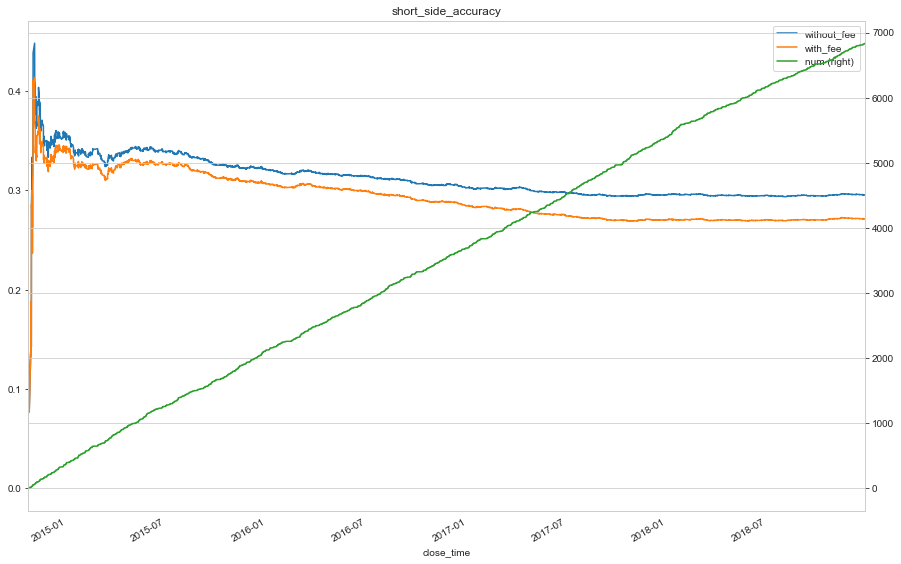

In [125]:
figure = plt.figure(figsize=(15,10))
short_accuracy_df = pd.DataFrame({'with_fee':short_accuracy_with_fee.values,'without_fee':short_accuracy_without_fee,'num':short_side['num'].cumsum()})
# plt.plot(long_accuracy_without_fee, label='long_side_without_fee')
# plt.plot(long_accuracy_with_fee,label='long_side_with_fee')
# plt.legend()
short_accuracy_df[['without_fee','with_fee','num']].plot(secondary_y='num',figsize=(15,10),title='short_side_accuracy')

In [127]:
def calculate_minutes(duration:pd.Series)->pd.Series:
    return duration.total_seconds()/60
hold_duration = trade_df_with_fee['duration'].apply(calculate_minutes)

In [132]:
open_postion_times = calculate_trades_result(engine.trades)['last_time']

In [137]:
history_data = engine.history_data


In [ ]:
# vol_list = []
# oi_list = []
# op_list = []
# hp_list = []
# lp_list = []
# cp_list = []


# for bar_data in history_data:
#     vol = bar_data.volume
#     oi = bar_data.open_interest
#     op = bar_data.open_price
#     hp = bar_data.high_price
#     lp = bar_data.low_price
#     cp = bar_data.close_price
#     symbol = bar_data.vt_symbol
    
#     vol_list.append(vol)
#     oi_list.append(oi)
#     op_list.append(op)
#     hp_list.append(hp)
#     lp_list.append(lp)
#     cp_list.append(cp)
# bar_df = pd.DataFrame('volume':vol_list,'open_inter')

In [148]:
history_data[-1].interval.value

'1m'